In [24]:
from rdflib import Graph 
import os
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.vectorstores import Chroma
from langchain.schema import Document
from sklearn.cluster import KMeans
import json
from dotenv import load_dotenv
load_dotenv()

True

In [4]:
# Load the graph
g = Graph()
g.parse("data/dunbar/bacnet.ttl", format="turtle")

<Graph identifier=N6d4450d8513144ebba79ce9b135a933a (<class 'rdflib.graph.Graph'>)>

In [9]:
# Bacnet Devices

# Create the documents to load into the vector store
documents = []

# Define a SPARQL query for bacnet_Device
query_for_devices = """
PREFIX bacnet: <http://data.ashrae.org/bacnet/2016#>

SELECT ?device_name
WHERE {
  ?device a bacnet:bacnet_Device ;
          bacnet:device_name ?device_name .
}
"""

# Run the query for devices
for row in g.query(query_for_devices):
    device_name = row[0]

    # Create the document
    content = device_name
    documents.append(Document(page_content=content, metadata={"type": "bacnet_device"}))

In [32]:
# Bacnet Points

# Create the documents to load into the vector store
documents = []

# Define a SPARQL query for bacnet_Point
query_for_points = """
PREFIX bacnet: <http://data.ashrae.org/bacnet/2016#>

SELECT ?device_name ?point_name ?present_value ?unit
WHERE {
  ?point a bacnet:bacnet_Point ;
         bacnet:device_name ?device_name ;
         bacnet:object_name ?point_name ;
         bacnet:present_value ?present_value ;
         bacnet:object_units ?unit .
}
"""

# Run the query for points
for row in g.query(query_for_points):
    device_name, point_name, present_value, unit = row
    
    content = point_name + " " + present_value + " " + unit
    documents.append(Document(page_content=content, metadata={"type": "bacnet_point"}))

In [33]:
# Load the documents into the vector store
api_key = os.getenv("OPENAI_API_KEY")
db = Chroma.from_documents(documents, OpenAIEmbeddings(api_key=api_key))

In [34]:
vectorstore_data = db.get(include=["embeddings", "metadatas"])
embs = vectorstore_data["embeddings"]

/Users/anthonydemattos/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Inertia for 1 clusters: 3884.3891329892203


/Users/anthonydemattos/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Inertia for 2 clusters: 3584.3285861918985


/Users/anthonydemattos/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Inertia for 3 clusters: 3386.917336208294


/Users/anthonydemattos/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Inertia for 4 clusters: 3205.5688899909424


/Users/anthonydemattos/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Inertia for 5 clusters: 3085.946830036578


/Users/anthonydemattos/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Inertia for 6 clusters: 3000.6117471354155


/Users/anthonydemattos/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Inertia for 7 clusters: 2946.1465757382944


/Users/anthonydemattos/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Inertia for 8 clusters: 2885.4215898296547


/Users/anthonydemattos/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Inertia for 9 clusters: 2824.794688332132


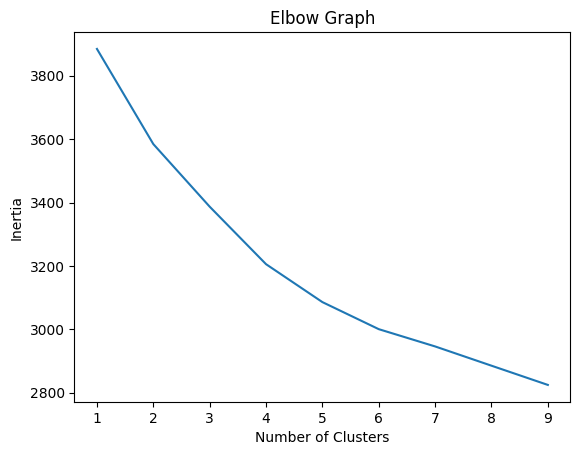

In [35]:
# Use the elbow method to find the optimal number of clusters
import matplotlib.pyplot as plt
import numpy as np

# Create the kmeans object
kmeans = KMeans()

# Create the list of inertias
inertias = []

# Loop through the number of clusters and calculate the inertia
for i in range(1, 10):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(embs)
    inertias.append(kmeans.inertia_)
    print("Inertia for {} clusters: {}".format(i, kmeans.inertia_))

# Plot the elbow graph
plt.plot(range(1, 10), inertias)
plt.title("Elbow Graph")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()

In [29]:
# Set the number of clusters from the elbow graph
num_clusters = 6

# Perform k-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
cluster_assignments = kmeans.fit_predict(embs)
cluster_assignments

/Users/anthonydemattos/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


array([0, 0, 0, 5, 5, 0, 0, 0, 5, 0, 5, 0, 5, 5, 5, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 5, 5, 5, 0, 5, 0, 0, 1, 1,
       3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3,
       3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 1, 1, 1, 1, 3, 3, 1,
       3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 5, 5, 0, 0, 0, 5, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 3, 1, 3, 3, 3, 3, 1,
       3, 3, 3, 3, 3, 1, 3, 1, 1, 3, 1, 1, 3, 1, 1,

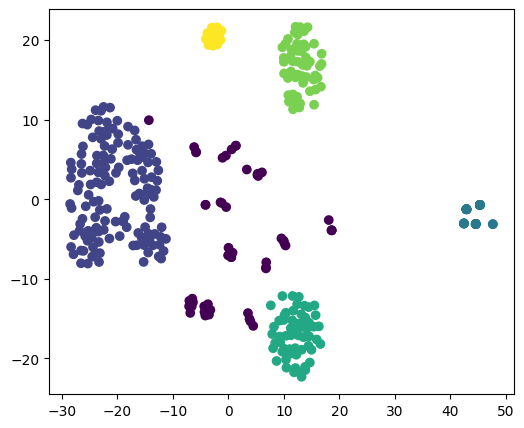

In [30]:
# Plot the clusters
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# Convert list to numpy array
embs_array = np.array(embs)

tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(embs_array)

plt.figure(figsize=(6, 5))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=cluster_assignments)
plt.show()